In [2]:
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pyupbit
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [5]:
class Data_preprocess() :
    def __init__(self, ticker=None, interval=None, to=None, count=None, df=None, csv_list=None) :
        self.df = df
        
        if ticker and interval and to and count :
            self.data, self.label, self.dataset = self.preprocess(pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count))
        
        elif  df :
            self.data, self.label, self.dataset = self.preprocess(df)
            
        elif csv_list :
            for csv_path in csv_list :
                try :
                    df = pd.read_csv(csv_path)
                    csv_data, csv_label, _ = self.preprocess(df)

                    fold_name = csv_path.split('\\')[-2]
                    file_name = csv_path.split('\\')[-1]
                    new_path = csv_path.replace(fold_name, 'preprocess_'+fold_name).replace(csv_path.split('\\')[-1],'')
                    os.makedirs(new_path, exist_ok=True)
                    
                    csv_dataset = pd.concat([csv_data, csv_label], axis=1)
                    csv_dataset.to_csv(os.path.join(new_path, file_name))
                    
                except :
                    print(f"ERROR from {csv_path}")
            
            
            
    def MinMax(self, dataset_df) :
        norm = MinMaxScaler()
        norm_dataset = norm.fit_transform(dataset_df)
        return pd.DataFrame(norm_dataset, columns=list(dataset_df.columns))
    
    
#     def add_after10(self, dataset_df) :
#         after10 = np.zeros_like(self.norm_dataset['close'])
#         for i in range(len(dataset_df['close']) - 1) :
#             after10[i] = dataset_df['close'][i + 1]
#         return after10
    def add_after10(self, dataset_df) :
        after10 = np.zeros_like(self.norm_dataset['close'])
        for i in range(len(dataset_df['close']) - 1) :
            if dataset_df['close'][i + 1] > dataset_df['close'][i] :
                after10[i] = 1
            else : 
                after10[i] = 0
            
        return after10
    
    
    def drop_feature(self, dataset_df) :
        # index(시간) 제거 
        if self.df :
            dataset_df = dataset_df.drop(columns=['Unnamed: 0'])
        else : 
            dataset_df = dataset_df.reset_index(drop=True)
        # value 제거
        dataset_df = dataset_df.drop(columns=['value'])
        return dataset_df
    
    
    def add_avgPrice(self, dataset_df) :
        return (dataset_df['high'] + dataset_df['low'] + 
                dataset_df['open'] + dataset_df['close']) // 4
       
    
    def preprocess(self, dataset, latest=False) :
        
        # drop feature
        dataset_df = self.drop_feature(dataset)
#         display(dataset_df)
        # avg_price 추가
        dataset_df['avg_price'] = self.add_avgPrice(dataset_df)
        
        if latest == True :
            # 가장 예전 데이터 삭제 - norm이랑 original 둘 다 적용
            self.dataset = self.dataset.drop([self.dataset.index[0]]).drop(columns=['after10'])
            self.norm_dataset = self.norm_dataset.drop([self.norm_dataset.index[0]])

            # ori dataset에 추가
            self.dataset = pd.concat([self.dataset, dataset_df])
            self.dataset = self.dataset.reset_index(drop=True)
            
            # min max 정규화 (MinMaxScaler) 적용
            self.norm_dataset = self.MinMax(self.dataset)
            
            # after10 추가
            self.dataset['after10'] = self.add_after10(self.dataset)
            
        
        else :
            # min max 정규화 (MinMaxScaler) 적용
            self.norm_dataset = self.MinMax(dataset_df)
            
            # after10 추가
            dataset_df['after10'] = self.add_after10(dataset_df)
        
        # 예측될 값(label)인 10분 후 가격
        self.norm_dataset['after10'] = self.add_after10(self.norm_dataset)
        
        # 마지막 행 삭제 (다음 가격을 모르므로 라벨을 붙일 수 없음)
        self.norm_dataset = self.norm_dataset.iloc[:-1]
        
        return self.norm_dataset.drop(columns=['after10']), self.norm_dataset['after10'], dataset_df
    


In [18]:
ticker = 'KRW-BTC'
interval ='minute10'
to = f'2022-02-23 08:30'
count = 1000

processed_data =  Data_preprocess(ticker, interval, to, count)
processed_data.dataset

,open,high,low,close,volume,avg_price,after10
0,53458000.0,53501000.0,53404000.0,53497000.0,48.929350,53465000.0,1.0
1,53497000.0,53580000.0,53495000.0,53549000.0,43.200104,53530250.0,0.0
2,53549000.0,53550000.0,53355000.0,53355000.0,62.350798,53452250.0,1.0
3,53360000.0,53505000.0,53310000.0,53484000.0,32.375780,53414750.0,0.0
4,53497000.0,53505000.0,53330000.0,53392000.0,35.808686,53431000.0,0.0
...,...,...,...,...,...,...,...
995,46000000.0,46184000.0,45998000.0,46155000.0,17.084831,46084250.0,0.0
996,46183000.0,46184000.0,46038000.0,46097000.0,23.687584,46125500.0,1.0
997,46097000.0,46159000.0,46093000.0,46159000.0,19.330314,46127000.0,1.0
998,46159000.0,46245000.0,46155000.0,46240000.0,16.882303,46199750.0,1.0


In [39]:
processed_data = pd.read_csv('./100000_dataset.csv')

6it [00:00, 200.24it/s]


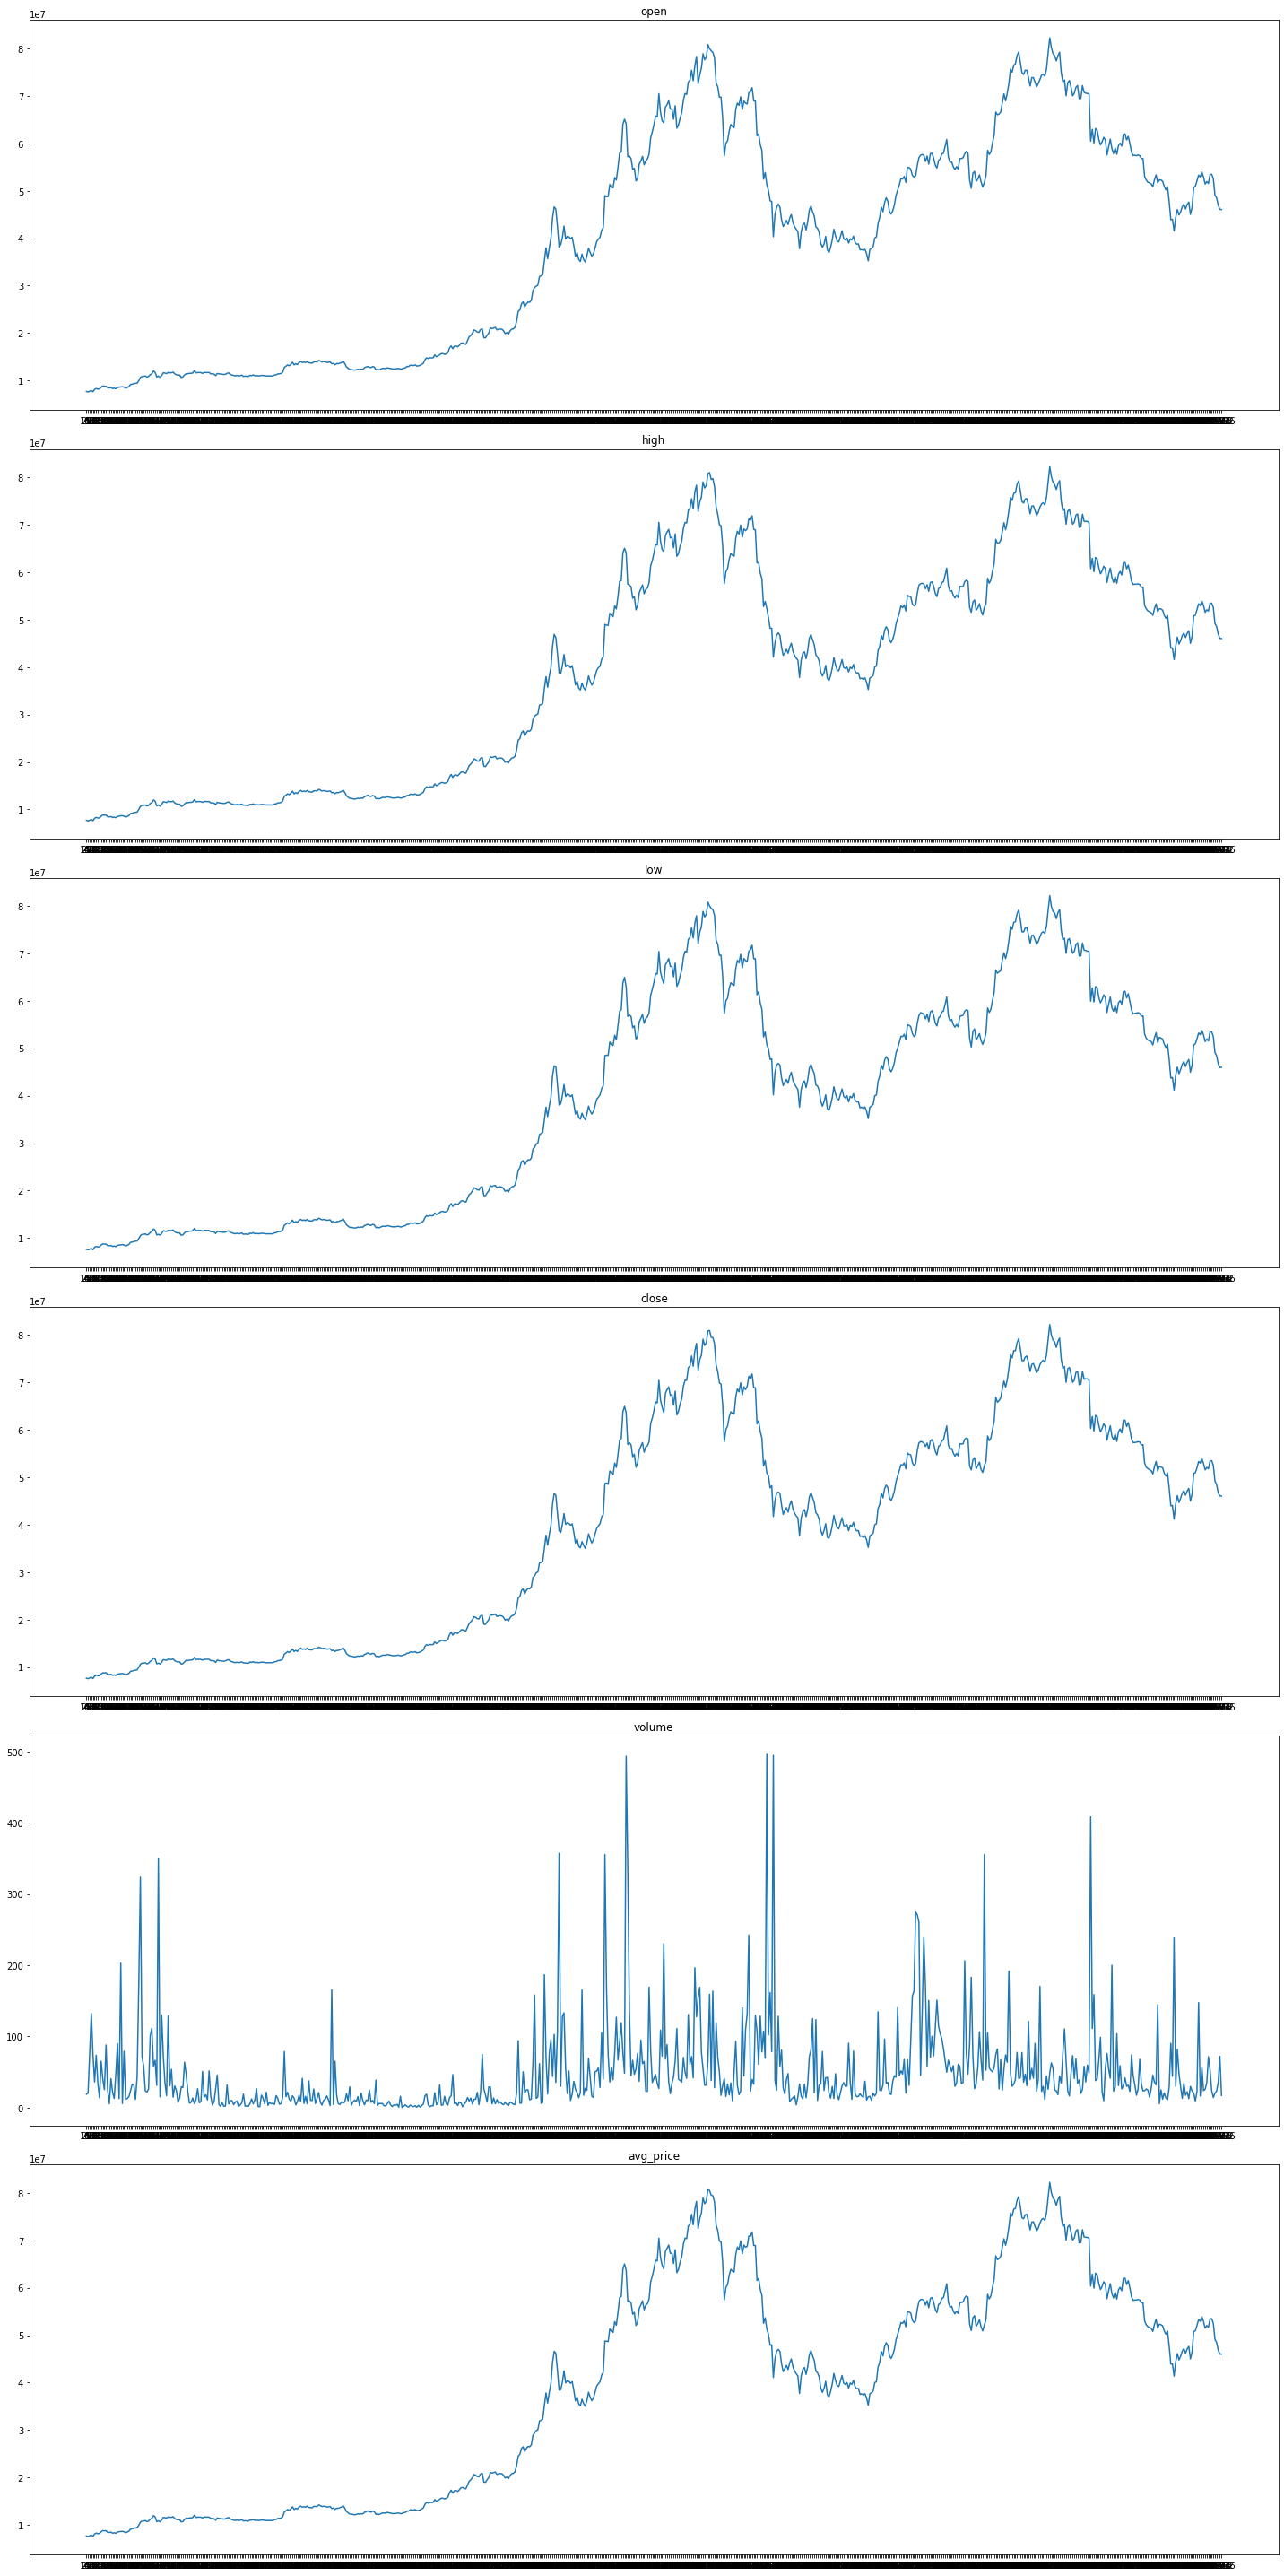

In [24]:
f, axs = plt.subplots(6,1 ,figsize=(20, 40))
preprocess_data = processed_data.drop(columns=['after10'])

for i, colunm in tqdm(enumerate(['open', 'high', 'low', 'close', 'volume', 'avg_price'])):
    x, y = zip(*list(preprocess_data[colunm][::144].items()))
    x = list(map(str, x))
    
    axs[i].plot(x, y)
#     axs[i].set_xticklabels(x, rotation = 90)
    axs[i].set_title(colunm)
f.tight_layout()
plt.show()

- 값을 하루 단위로 표현함
- 상승추세를 가짐
- Volum 값은 엄청 튐

# MinMax 적용

6it [00:00, 214.53it/s]


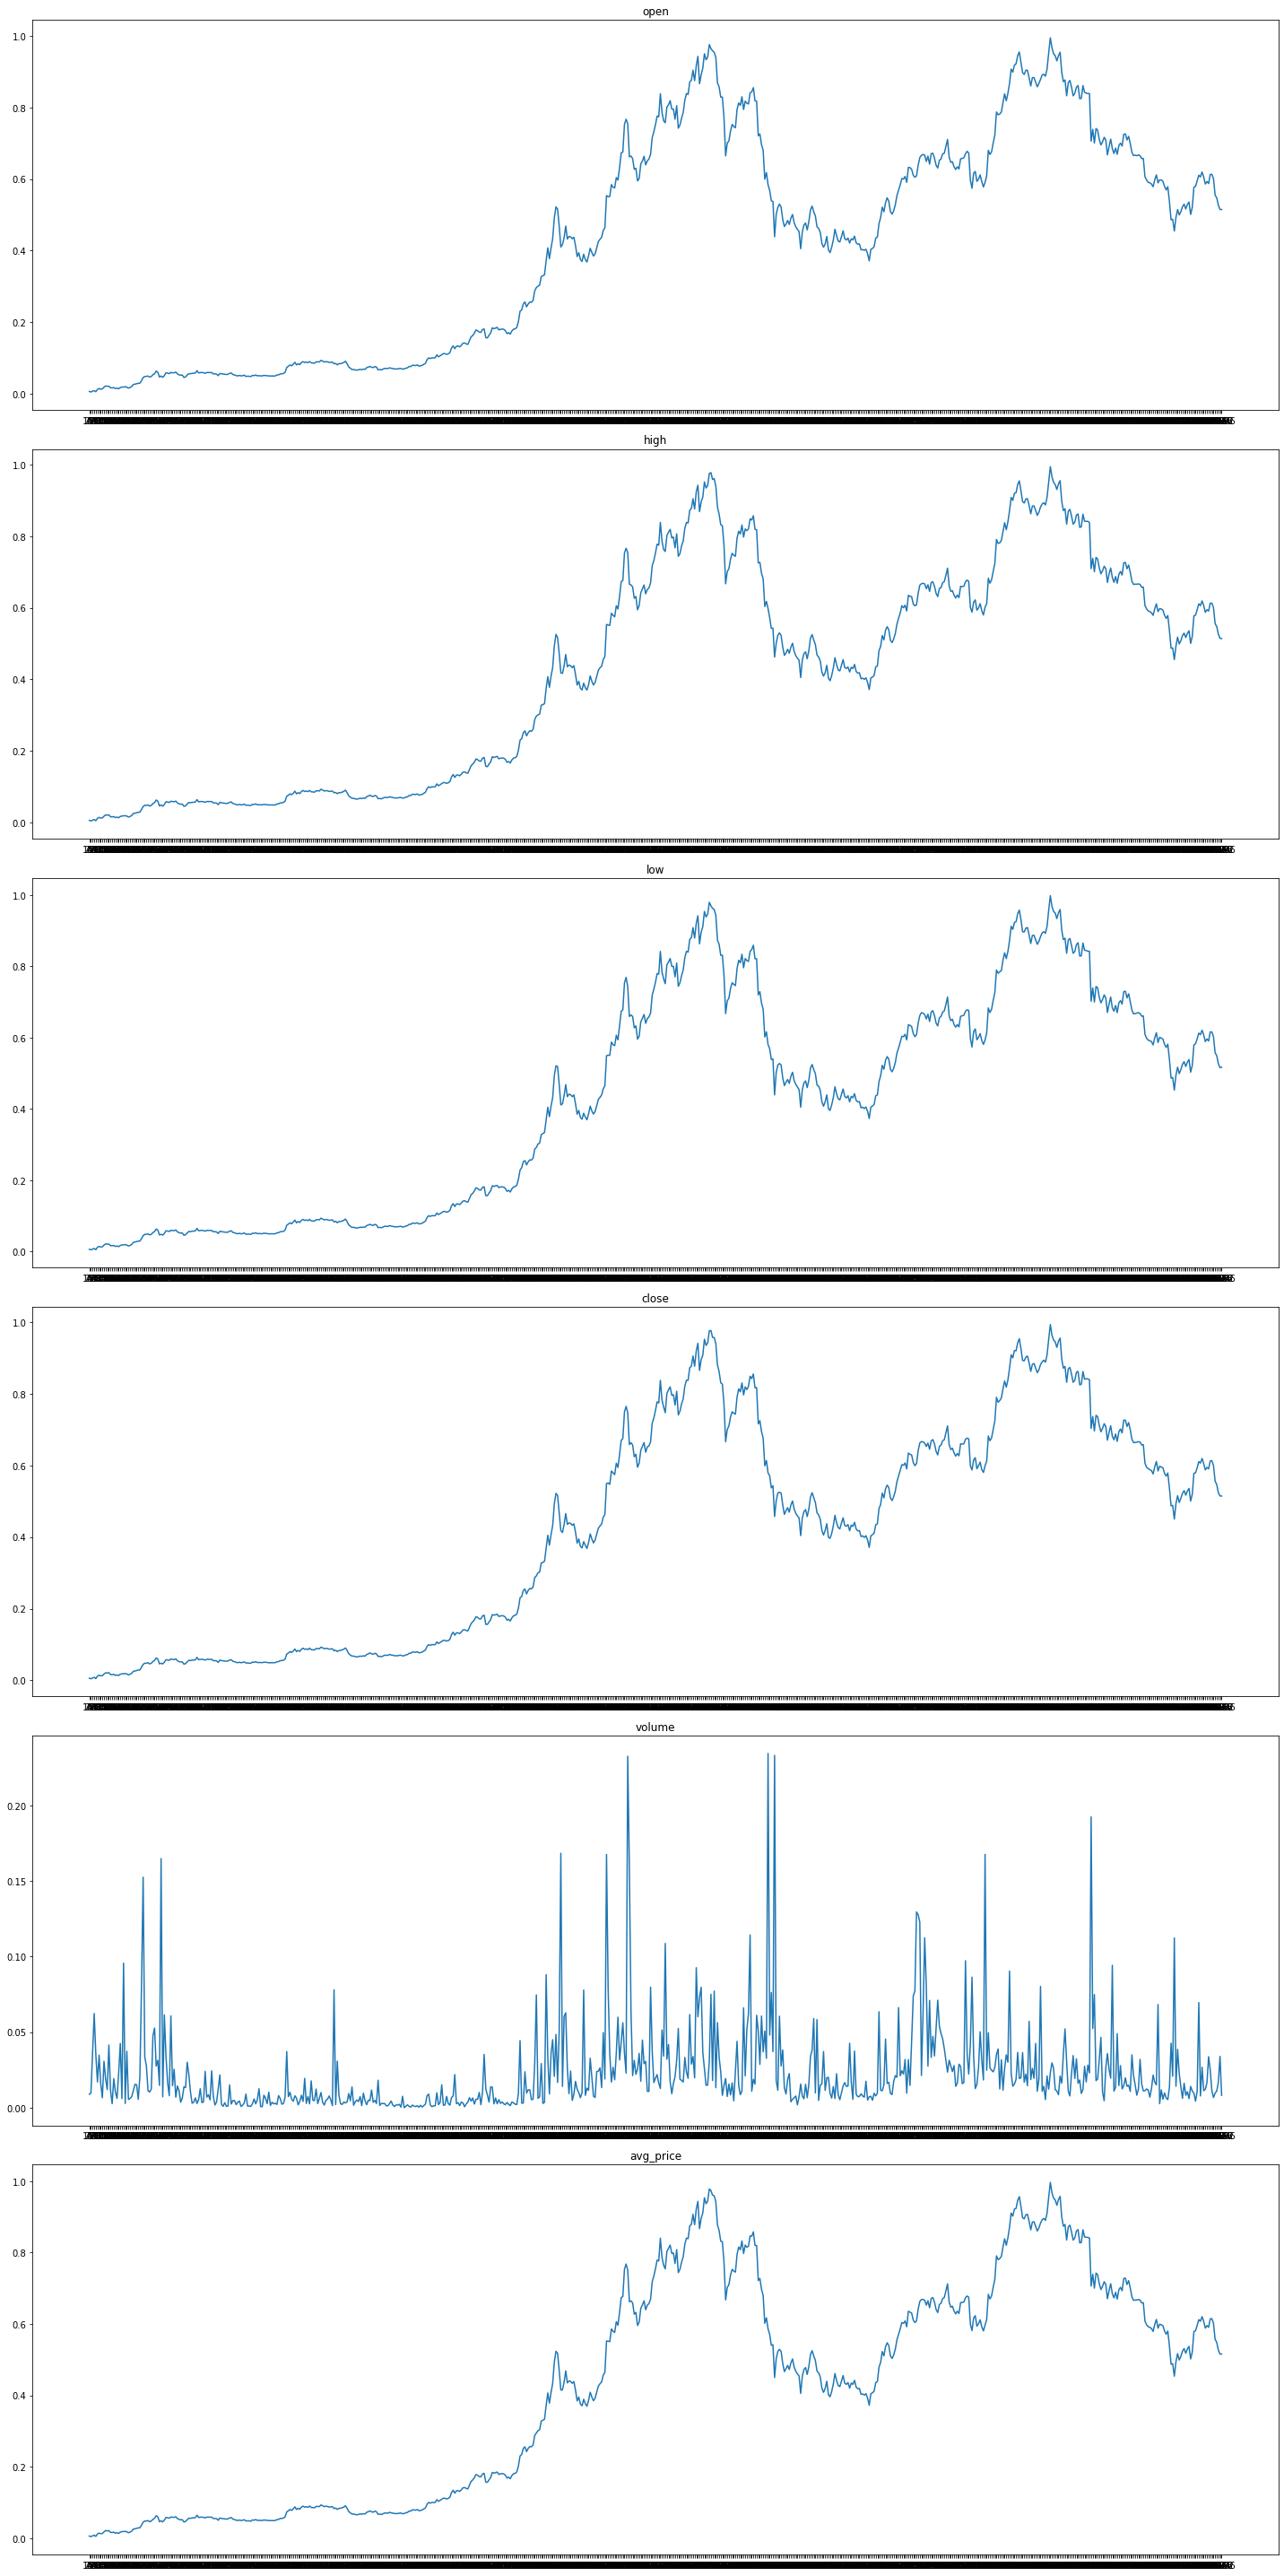

In [27]:
f, axs = plt.subplots(6,1 ,figsize=(20, 40))
preprocess_data = processed_data.drop(columns=['after10'])

norm = MinMaxScaler()
norm_dataset = norm.fit_transform(preprocess_data)
minmax_data = pd.DataFrame(norm_dataset, columns=list(preprocess_data.columns))

for i, colunm in tqdm(enumerate(['open', 'high', 'low', 'close', 'volume', 'avg_price'])):
    x, y = zip(*list(minmax_data[colunm][::144].items()))
    x = list(map(str, x))
    
    axs[i].plot(x, y)
    axs[i].set_title(colunm)
    
f.tight_layout()
plt.show()


- MinMax 를 적용해도 어림 없음
- 상승 추세를 없앨 수 없음
- 다른 값들에 비해 Volum의 값이 매우 작아서 0 ~ 0.3 사이에 모든 값이 분포하는 것을 볼 수 있음
- MinMax 값으로는 훈련이 안됨

# Log 변환

6it [00:00, 206.87it/s]


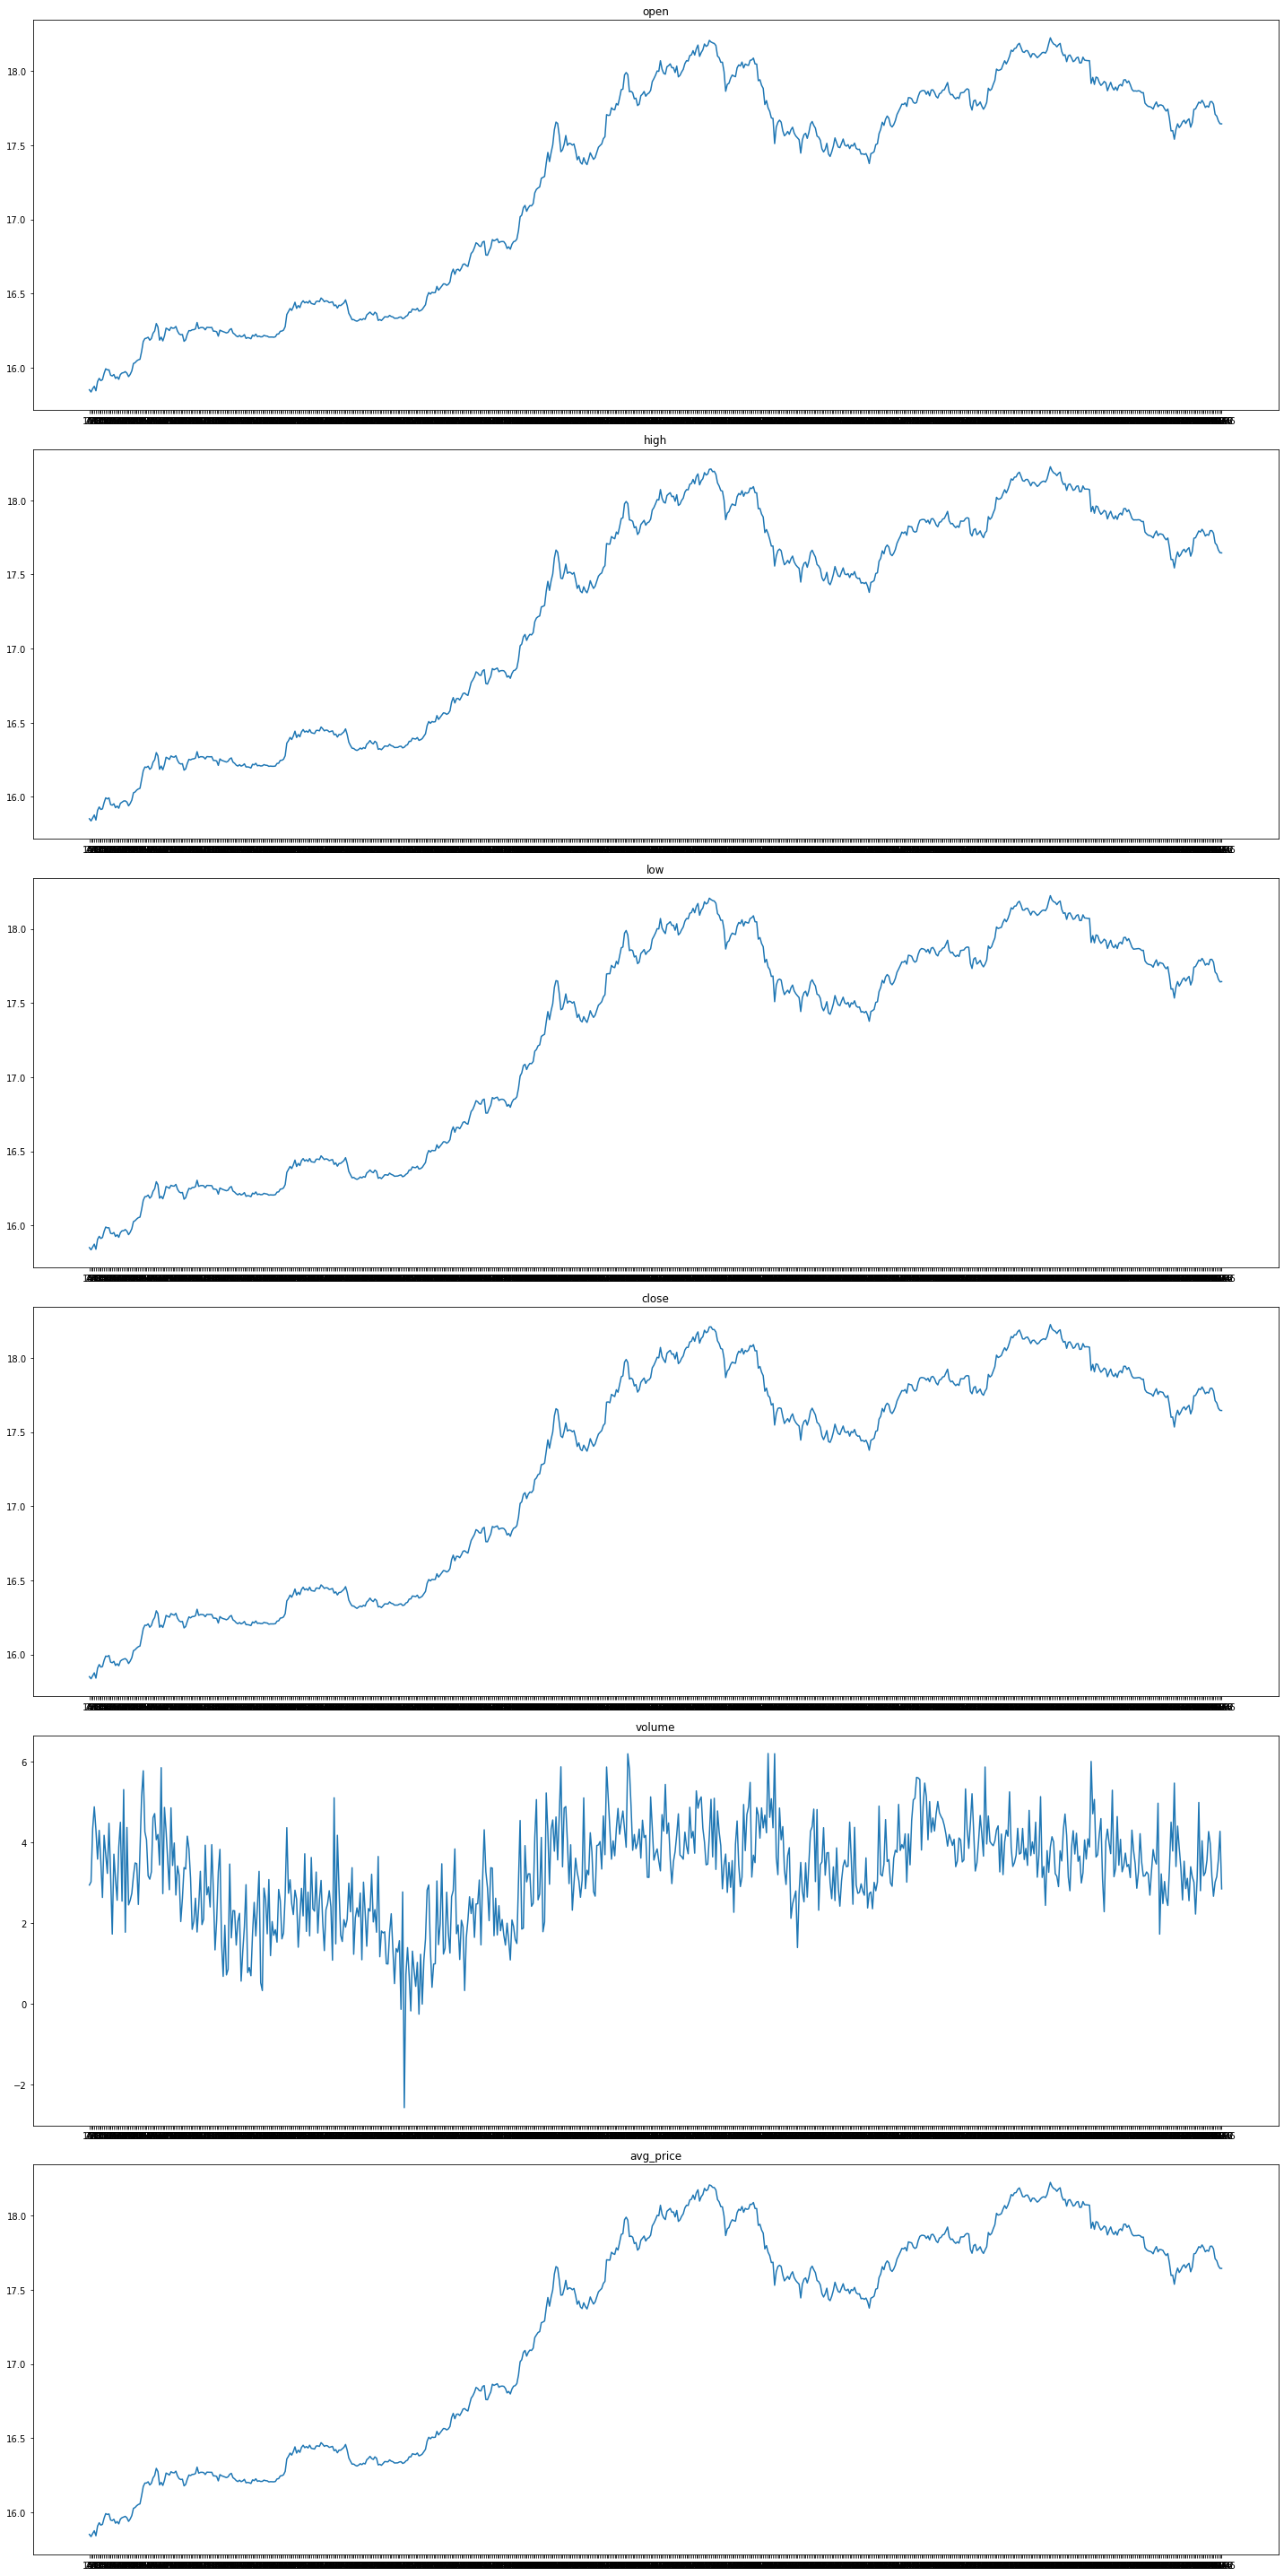

In [40]:
f, axs = plt.subplots(6,1 ,figsize=(20, 40))
preprocess_data = processed_data.drop(columns=['after10'])


for i, colunm in tqdm(enumerate(['open', 'high', 'low', 'close', 'volume', 'avg_price'])):
    x, y = zip(*list(preprocess_data[colunm][::144].items()))
    x = list(map(str, x))

    log_y = np.log(y)
    
    axs[i].plot(x, log_y)
    axs[i].set_title(colunm)
    
f.tight_layout()
plt.show()


- MinMax에 비해서 값의 상승폭과 하락폭이 줄긴함
- 값의 편차가 여전히 너무 큼 (17 ~ 35 사이값)

# Log 변환 + Diff (차분) 적용

6it [00:00, 200.00it/s]


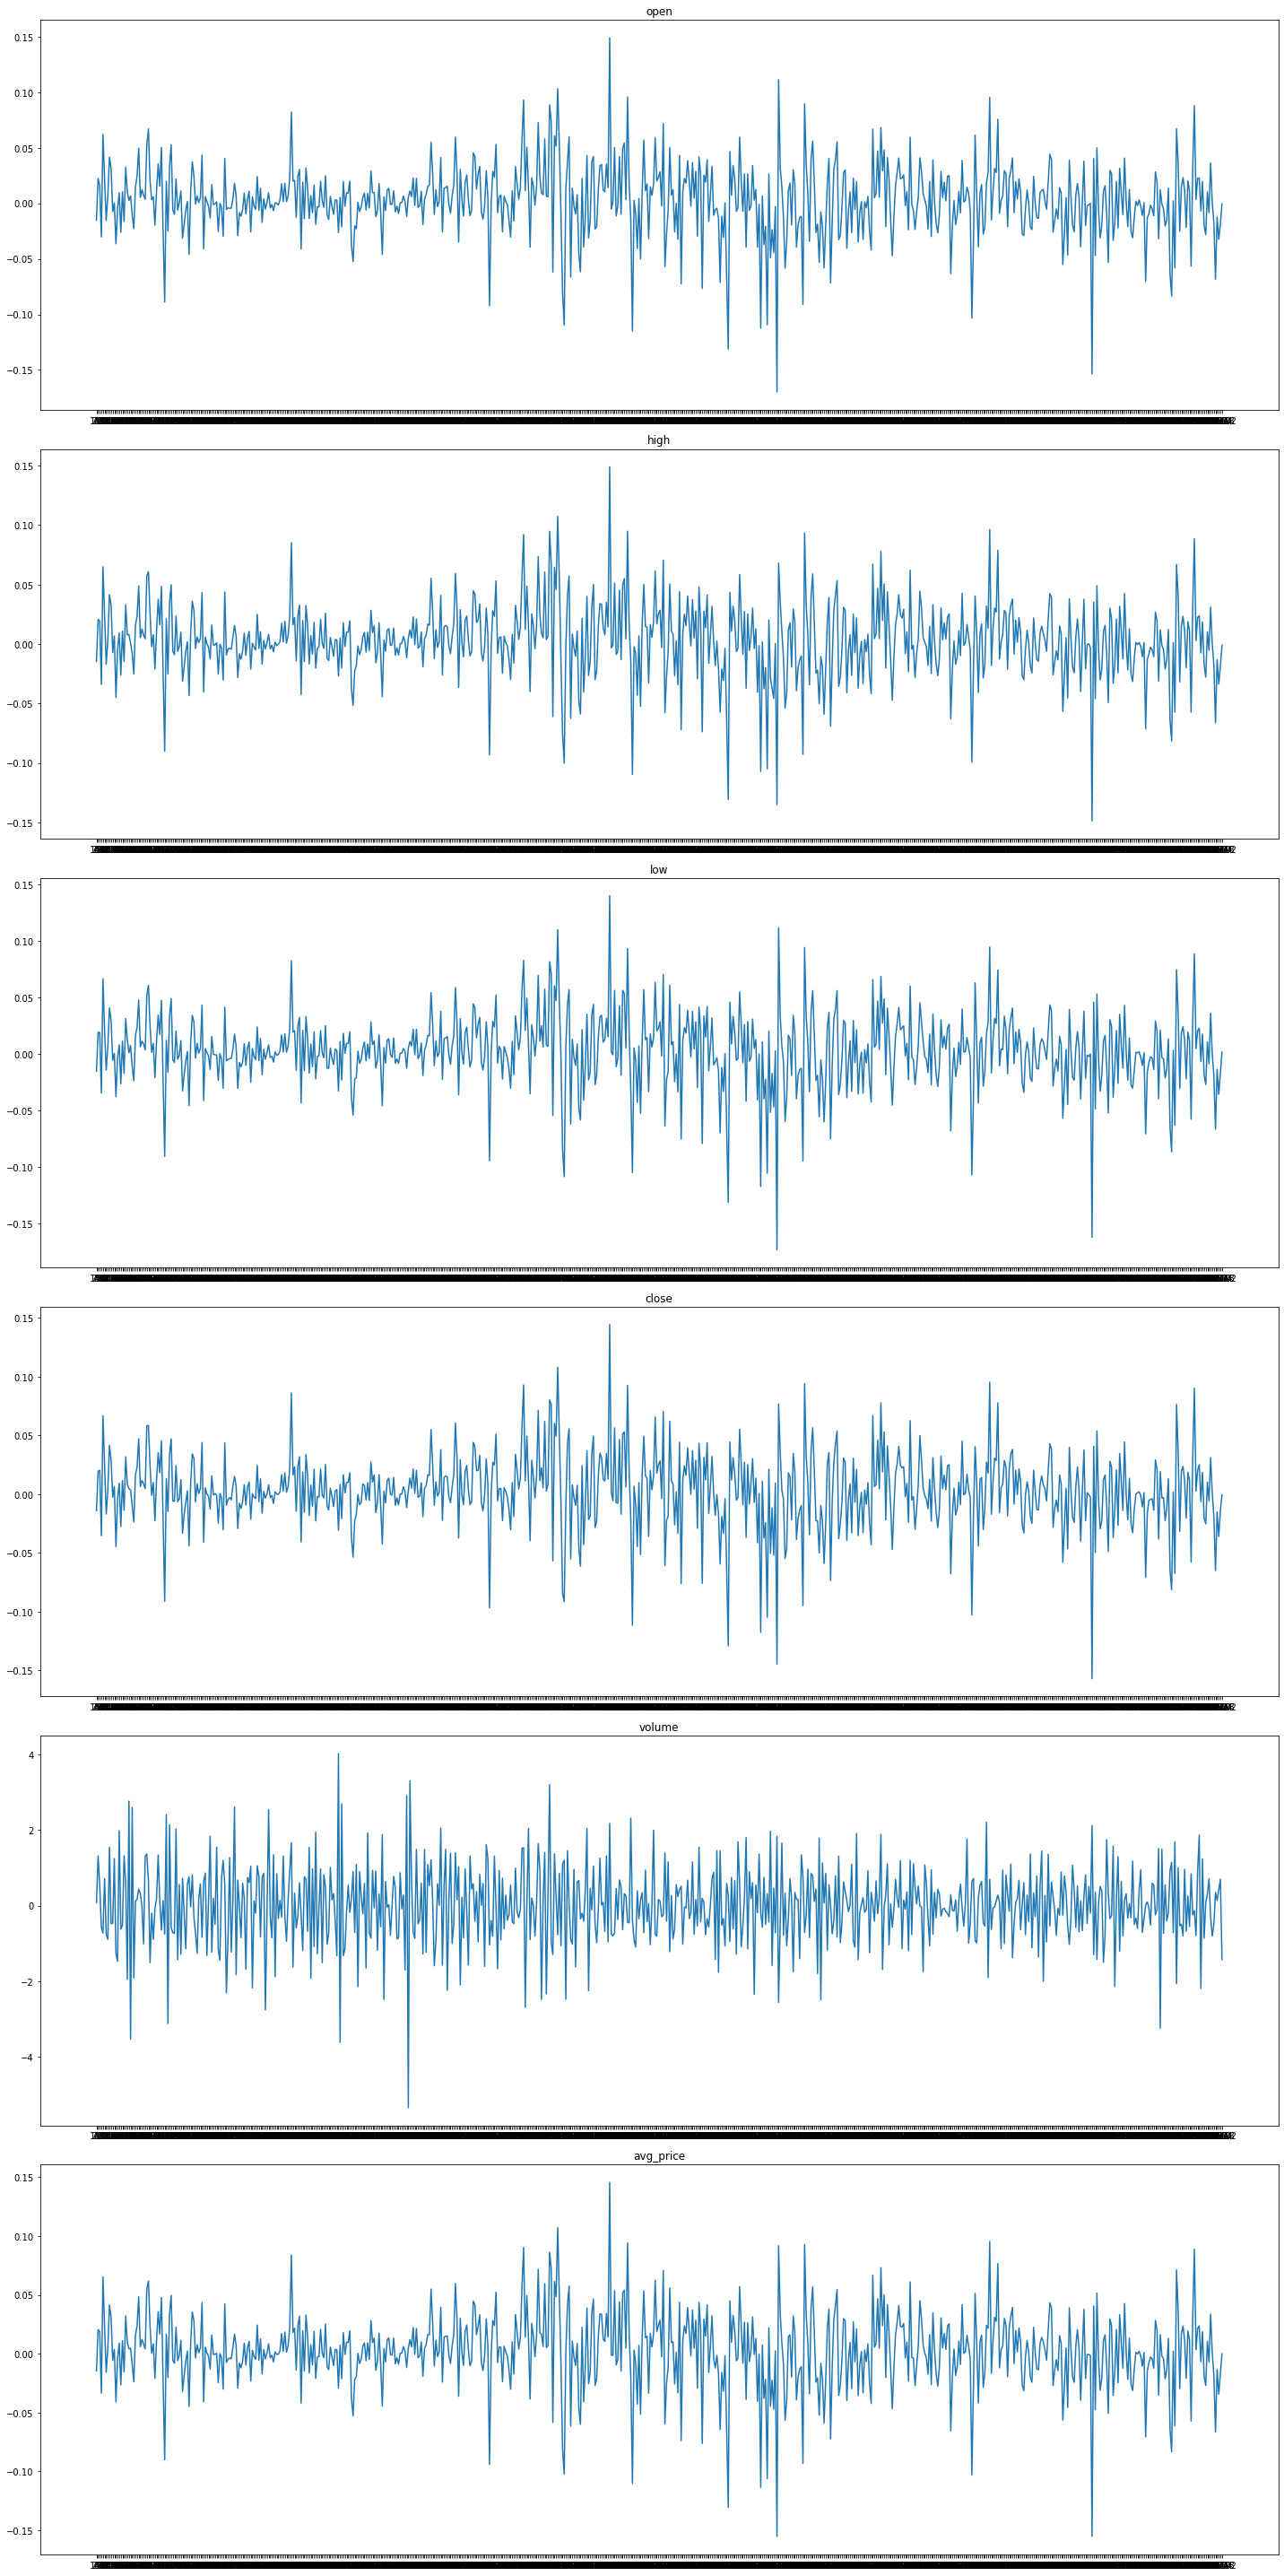

In [44]:
f, axs = plt.subplots(6,1 ,figsize=(20, 40))
preprocess_data = processed_data.drop(columns=['after10'])


for i, colunm in tqdm(enumerate(['open', 'high', 'low', 'close', 'volume', 'avg_price'])):
    x, y = zip(*list(preprocess_data[colunm][::144].items()))
    x = list(map(str, x))

    log_y = np.log(y)
    diff_y = np.diff(log_y)

    axs[i].plot(x[:-1], diff_y)
    axs[i].set_title(colunm)
    
f.tight_layout()
plt.show()


- 추세가 완전히 없어짐
- 값의 편차도 크지 않음
- Volum 값의 범위만 너무 큼 (-5 ~ 4)

# 평균정규화

6it [00:00, 158.98it/s]


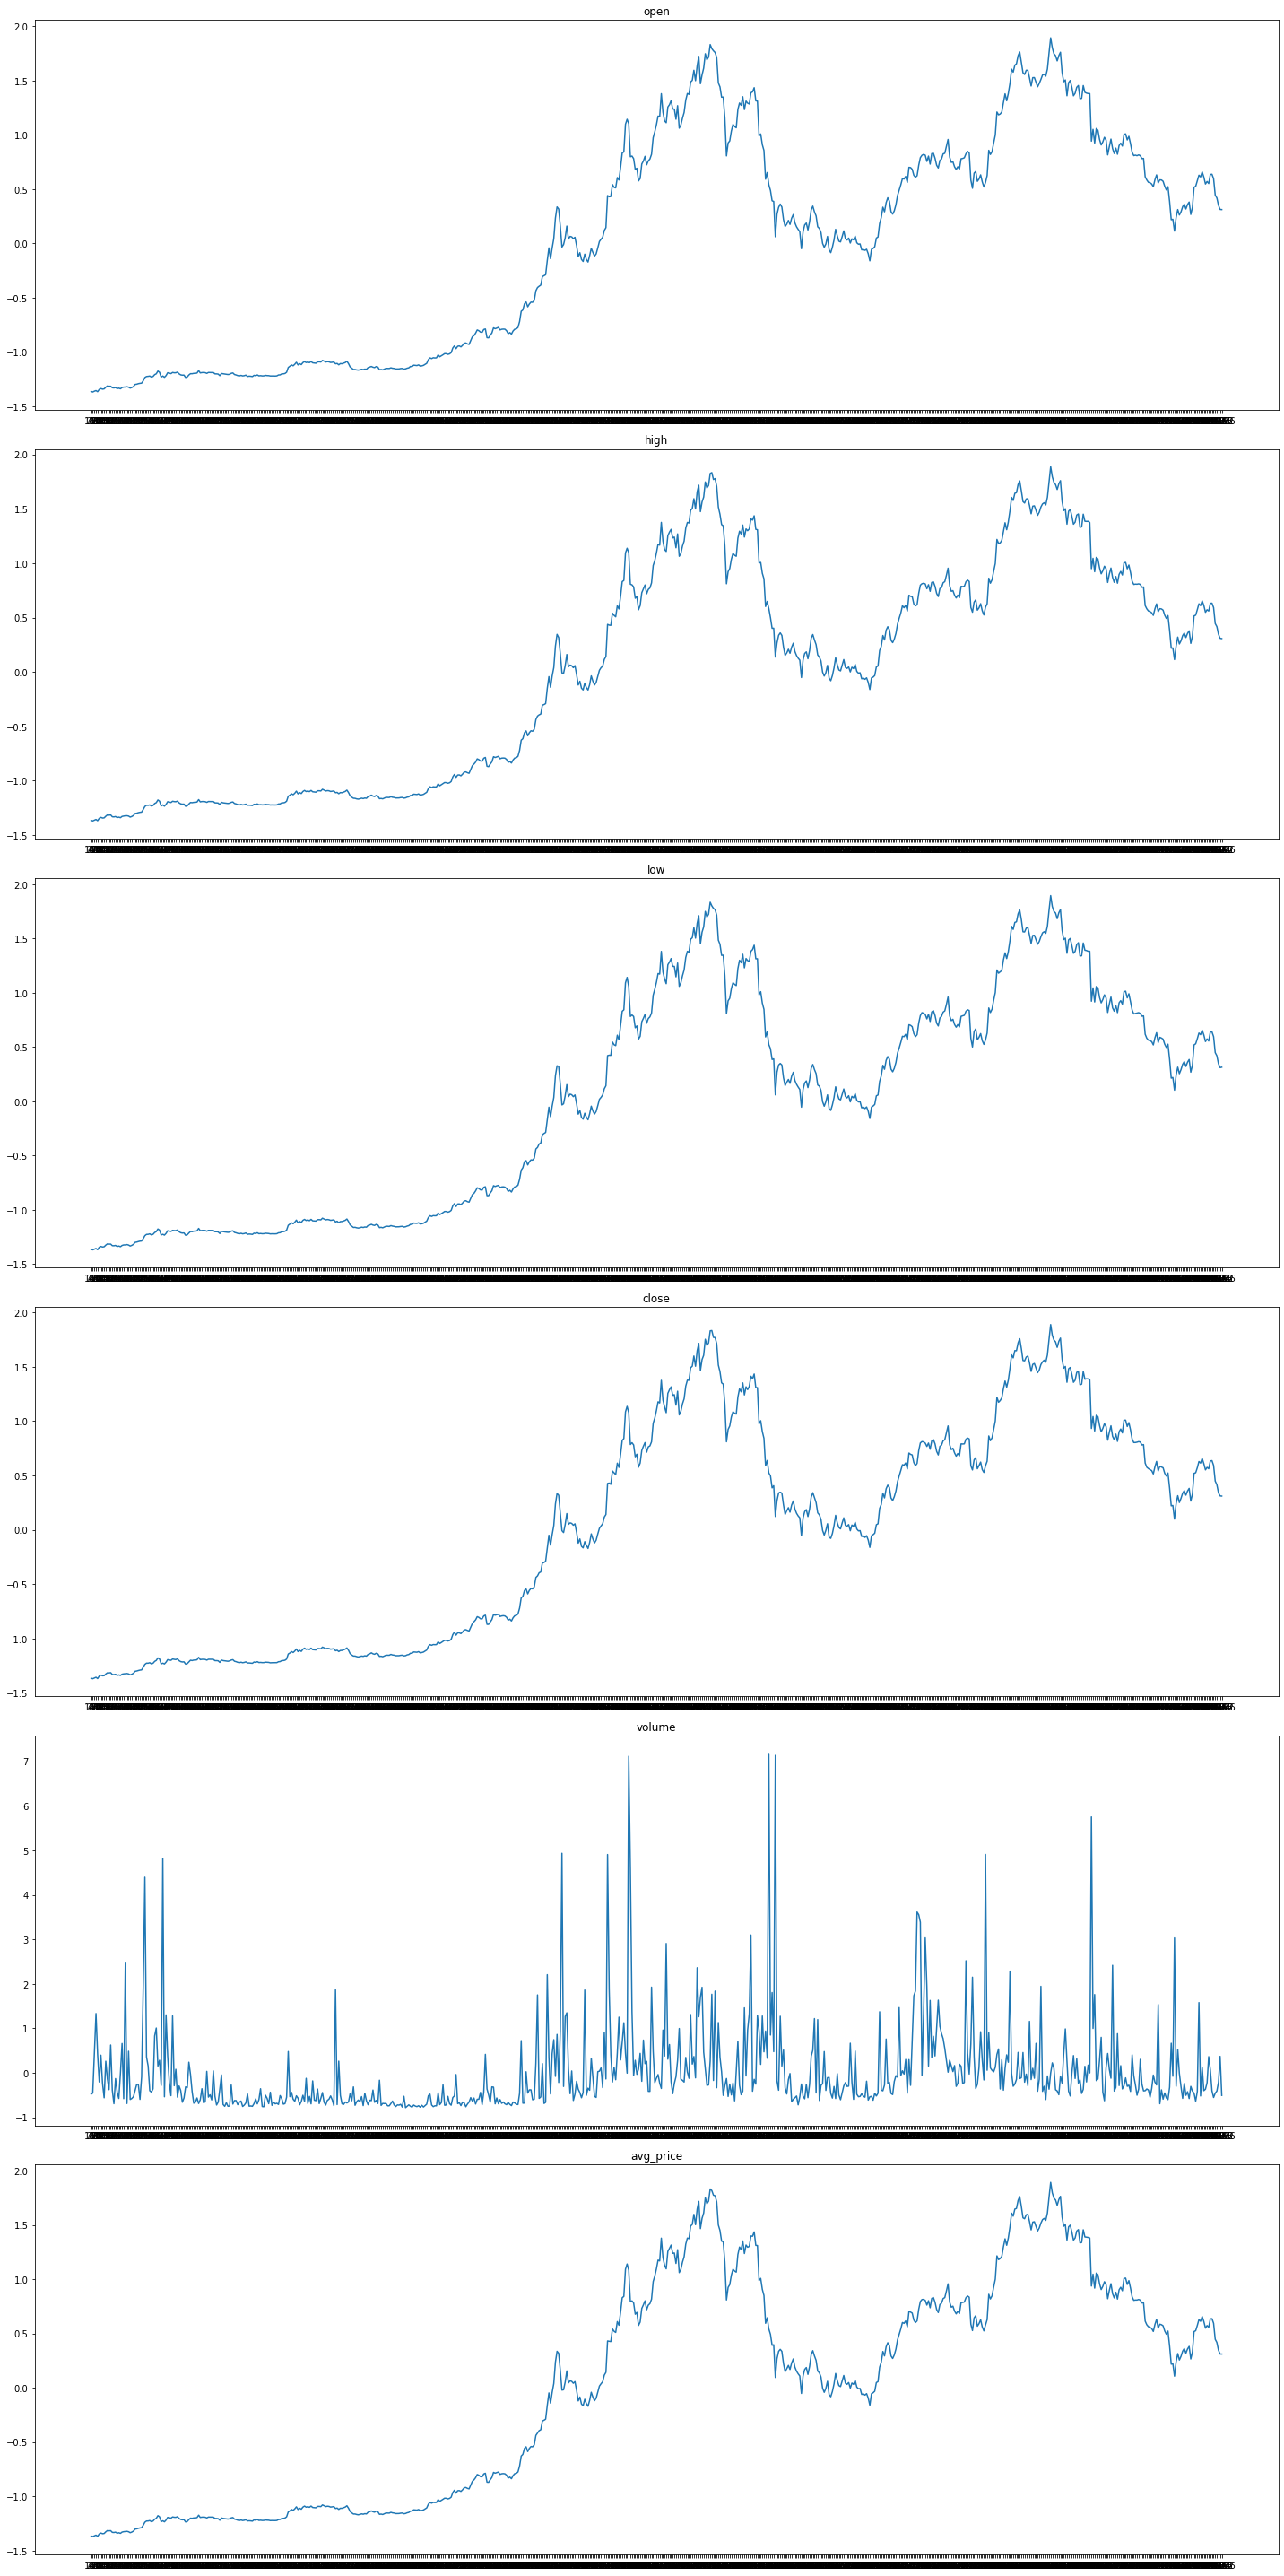

In [47]:
f, axs = plt.subplots(6,1 ,figsize=(20, 40))
preprocess_data = processed_data.drop(columns=['after10'])


for i, colunm in tqdm(enumerate(['open', 'high', 'low', 'close', 'volume', 'avg_price'])):
    mean_norm_data = (preprocess_data[colunm][::144] - preprocess_data[colunm][::144].mean()) / preprocess_data[colunm][::144].std()

    x, y = zip(*list(mean_norm_data.items()))
    x = list(map(str, x))
    
#     log_y = np.log(y)
#     diff_y = np.diff(log_y)

    axs[i].plot(x, y)
    axs[i].set_title(colunm)
    
f.tight_layout()
plt.show()


- 어림도 없음
- 추세 제거 안됨
- volum 값이 여전히 튐